# Lending Club Case Study
Lending Club a renowned finance company which lends loans to customers has to go through few steps before approving a loan. When the applicant drafts his or her willingness for loan, the company must check the eligibility of each customer before processing a loan. There are two types of risks associated with the bank's decision

- If the applicant is **likely to repay the loan**, then **not approving the loan results in a loss of business** to the company
- If the applicant is **not likely to repay the loan**, i.e., he/she is **likely to default then approving the loan may lead to a financial loss** for the company.

## Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

## Functions

In [26]:
get_shape = lambda x: f"Shape of dataset is {x[0]} Rows x {x[1]} Columns" # applicable 2D datasets

def detect_dim_change(df_old, df_new):
    r_change, c_change = df_new.shape[0] - df_old.shape[0], df_new.shape[1] - df_old.shape[1]
    return f'''Changes identified: 
    -------> Rows changes = {r_change}
    -------> Cols changes = {c_change}'''


RTEXT, GTEXT, BTEXT = '\033[2;31;49m', '\033[2;32;49m', '\033[2;34;49m'
RESET_CLR = '\033[0;0m'

# print(RTEXT+"RED", GTEXT+"GREEN", BTEXT+"BLUE", RESET_CLR)

## Loading Data

In [27]:
# raw data
raw_df = pd.read_csv("./loan/loan.csv")
raw_df.head(2)

C:\Users\Vinay.Narayana\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [28]:
print(get_shape(raw_df.shape))
# raw_df.info() # check columns vs datatypes - as there are more columns, we need to use verbose=True to force this command to display results

Shape of dataset is 39717 Rows x 111 Columns


## Data Processing

### Nulls - Analysis

From above data frame display, we are able to see so many null values.

**Objective**: At the end of this phase, we will have more convenient data *to reason for* than wondering about many nulls in later steps of EDA

**Process Outline**:
1. We will drop all the 100% null valued columns as they don't serve any purpose
2. We will also maintain some threshold of nulls to discard columns

We have total 111 columns; to get an idea about presence of nulls and it's percentage in dataset, we are generating following visualizations.

#### Heatmap

1. Column having null values are represented as white lines
2. Heatmap visualization allows use to inspect for rows having nulls as well (it is represented as continuous horizontal line)

<AxesSubplot:>

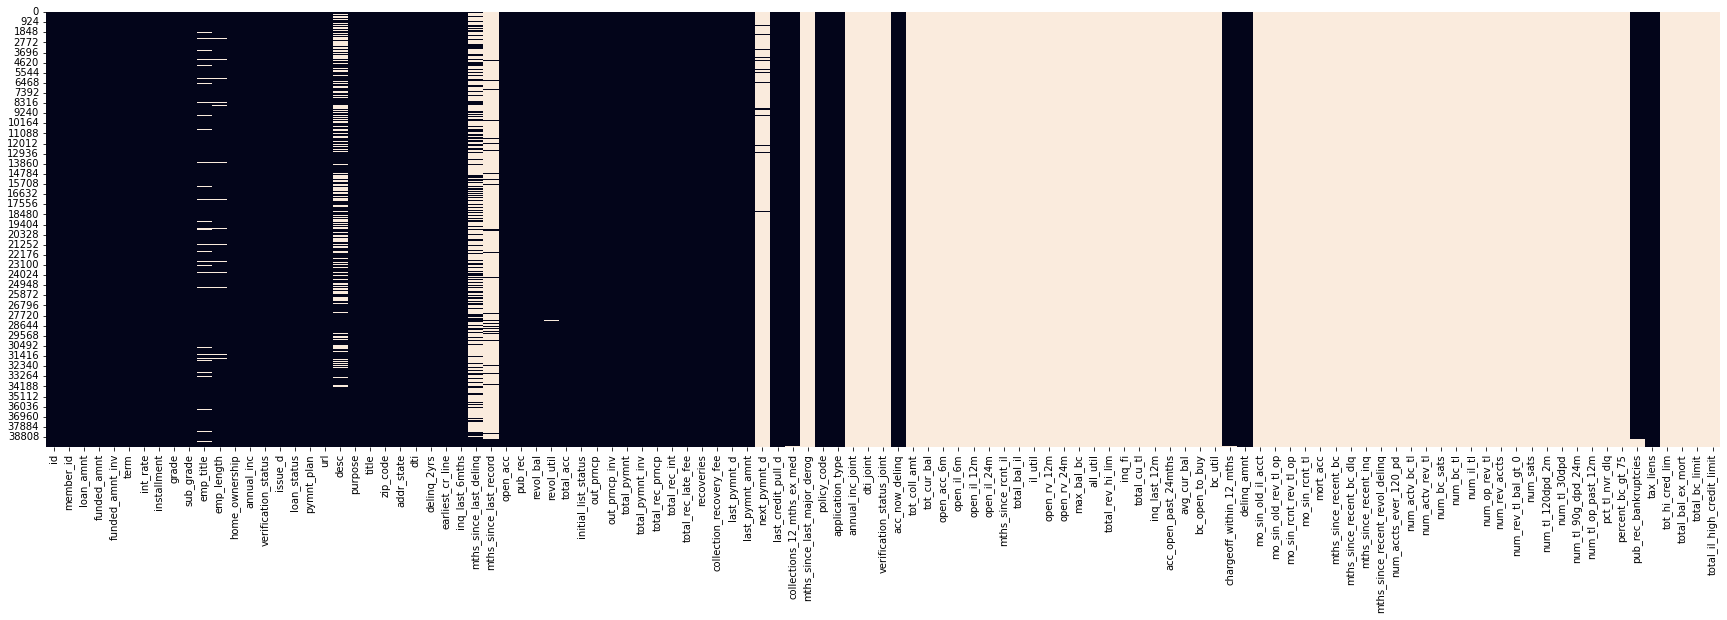

In [29]:
# visualize missing values - a step to understand where the data is missing for which columns
plt.figure(figsize=(30,8))
sns.heatmap(raw_df.isnull(), cbar=False)

##### Result Analysis:
1. From the above image we can see that most of the columns are having null values

#### Calculate % of Nulls

Performing this step to analyse the remove the columns with specific threshold and % of nulls

In [30]:
# calculate nulls percentage for each column
df_nulls_summary = ((raw_df.isnull().sum()/raw_df.shape[0])*100).reset_index().rename(columns = {'index': 'column', 0: 'Nulls_%age'})
df_nulls_summary.sample(n=6, random_state=12) # performed sampling here, as head and tail either gives 0 or 100% nulls

,column,Nulls_%age
36,out_prncp,0.000000
21,title,0.027696
19,desc,32.580507
101,num_tl_90g_dpd_24m,100.000000
39,total_pymnt_inv,0.000000
14,verification_status,0.000000


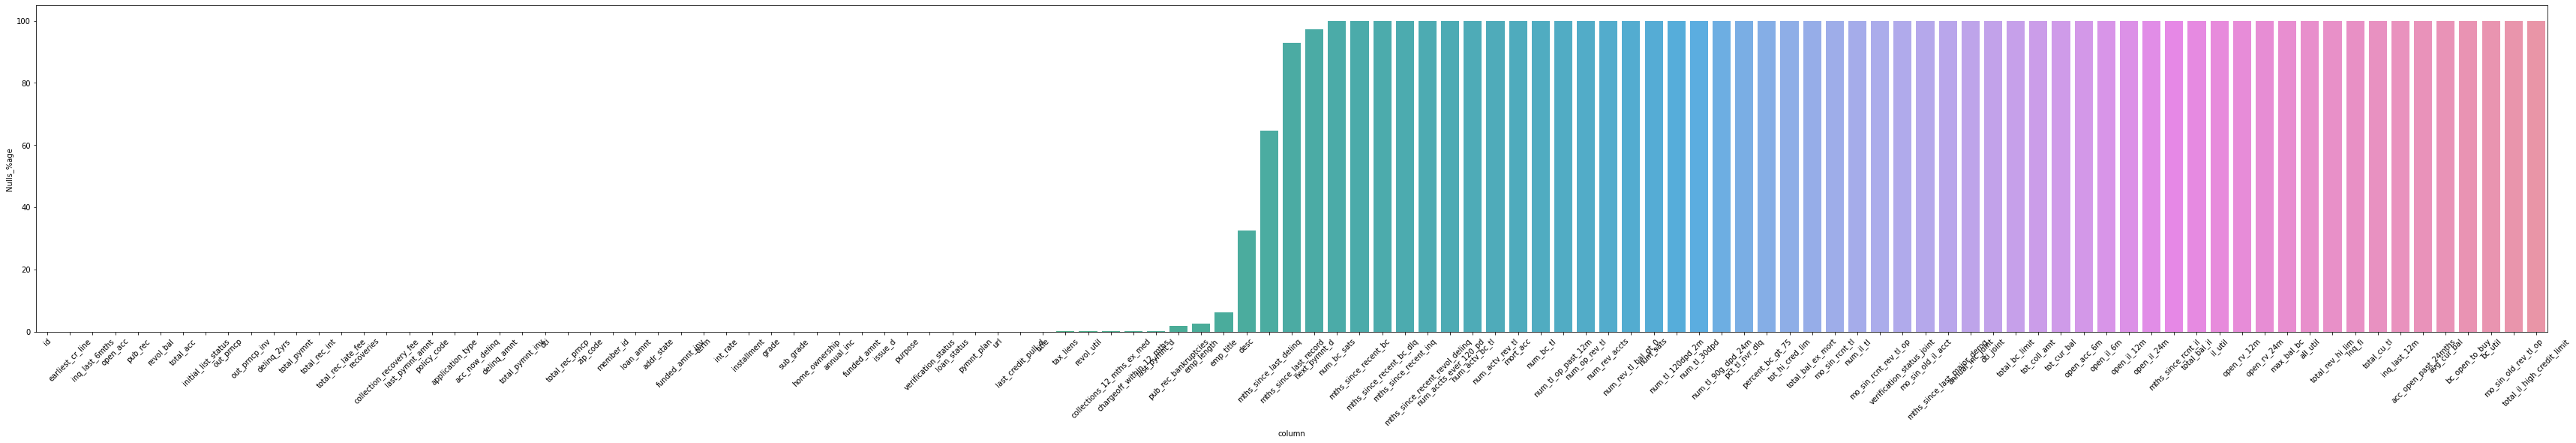

In [31]:
plt.figure(figsize=(60, 8))
plt.xticks(rotation=45)
_ = sns.barplot(data=df_nulls_summary.sort_values('Nulls_%age'), x='column', y='Nulls_%age')

#### Frequency plot Nulls_%age vs Columns count

This plot helps us to understand how many columns are having nearest rounded Nulls %

Non-null columns: 50


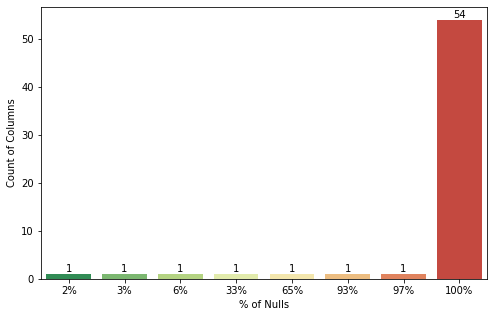

In [32]:
df_null_summary_rounded = df_nulls_summary.groupby(df_nulls_summary['Nulls_%age'].apply(round))[['Nulls_%age']].agg(CountOfColumns = ('Nulls_%age', 'count')).reset_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_null_summary_rounded[df_null_summary_rounded['Nulls_%age']!=0], x='Nulls_%age', y='CountOfColumns', palette="RdYlGn_r")

ax.set_xticklabels([f'{x}%' for x in df_null_summary_rounded[df_null_summary_rounded['Nulls_%age']!=0]['Nulls_%age']])
plt.xlabel("% of Nulls")
plt.ylabel("Count of Columns")

_ = ax.bar_label(ax.containers[0])
print("Non-null columns:", df_null_summary_rounded[df_null_summary_rounded['Nulls_%age']==0]['CountOfColumns'].tolist()[0])

##### Result Analysis

1. We can notice there are ***50 Columns with no null*** & ***54 columns with and around 100% Nulls***
2. We will be removing columns having nulls above <u>30% i.e., total 58 columns</u>

### Removing columns with all the nulls

In [33]:
# normally columns with more than 50% missing values is useless because over imputing the data can either overestimate or underestimate
removed_columns = df_nulls_summary[df_nulls_summary['Nulls_%age'].apply(round) > 30]['column'].tolist()
print(len(removed_columns), removed_columns)

58 ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', '

In [34]:
df_na_fix = raw_df[[x for x in raw_df.columns if x not in removed_columns]]

print(detect_dim_change(raw_df, df_na_fix))
print(get_shape(df_na_fix.shape))

Changes identified: 
    -------> Rows changes = 0
    -------> Cols changes = -58
Shape of dataset is 39717 Rows x 53 Columns


### Empty Rows Analysis

Check if entire row is null or empty, if so then we will remove that rows

In [35]:
row_wise_na_summary = ((df_na_fix.isnull().sum(axis=1)/ len(df_na_fix.columns))*100).reset_index().rename(columns = {'index' : 'RowNumber', 0:'Nulls_%age'}).sort_values('Nulls_%age', ascending=False)
row_wise_na_summary.head(1)

,RowNumber,Nulls_%age
39706,39706,9.433962


*There are no empty/ null rows*

### Data Types

Since there were many columns, we are doing data types fix related analysis now.

In other words, doing data types fixes or null values analysis on dropping columns is unnecessary.

#### Reading data dictionary (columns with description)

1. This helps us to lookup for any column description during the analysis.
2. We will also discard the columns which got dropped in Null Analysis

In [36]:
df_dictionary = pd.read_excel("./loan/Data_Dictionary.xlsx", sheet_name="LoanStats")
df_dictionary.head(2)
print(get_shape(df_dictionary.shape))

Shape of dataset is 117 Rows x 2 Columns


In [37]:
pd.set_option('max_colwidth', None)
df_dictionary[df_dictionary['LoanStatNew'].isin(df_na_fix.columns)].head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
10,chargeoff_within_12_mths,Number of charge-offs within 12 months


In [38]:
# df_dictionary[df_dictionary['LoanStatNew'].isin(sorted(df_na_fix.columns))].reset_index(drop=True).to_csv("required_cols.csv") # save required_cols with description
# df_na_fix[sorted(df_na_fix.columns)].loc[0, :] # sample row
# df_na_fix[sorted(df_na_fix.columns)].dtypes # sample row dtypes

#### Parsing with required data types

Parsing columns with required data types will help us to categorize columns properly
Determining data types is done as follows:
1. Column description
2. Number of unique values to further determine if it is **category** i.e., with finite few set of values
3. Dates, percentages % converted to float continuous

We have also dropped the columns which are having only ***1 unique value*** across the dataset

In [39]:
date_cols = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d'] #'earliest_cr_line'
percentage_cols = ['int_rate', 'revol_util']

ignorable_cols = ['member_id', 'url', 'title', 'emp_title', 'zip_code']

col_changes = {}

def parse_dtype(df, each_col):
    global date_cols, percentage_cols

    if each_col in date_cols:
        df[each_col] = df[each_col].apply(lambda x: dt.datetime.strptime(str(x), "%b-%y") if not pd.isna(x) else x)

    elif each_col in percentage_cols:
        df[each_col] = df[each_col].apply(lambda x: float(str(x).replace("%", '')) if not pd.isna(x) else x)
    return df

def isFewUnique(df, each_col):
    unique_vals = df[each_col].unique().tolist()
    n = len(unique_vals)
    if n <= 1:
        col_changes[each_col] = RTEXT + f'Dropping as only 1 unique value -> {unique_vals}' + RESET_CLR
        return df.drop(each_col, axis=1)
    elif n <= 20:
        col_changes[each_col] = BTEXT + f'Casted to Category dtype -> {unique_vals}' + RESET_CLR
        return df.astype({each_col: 'category'})
    else:
        col_changes[each_col] = 'No Change'
        return df

In [40]:
print(get_shape(df_na_fix.shape))

Shape of dataset is 39717 Rows x 53 Columns


In [41]:
df_dtypes_fix = df_na_fix[df_na_fix.loan_status!='Current'].copy(deep=True) ## discarding current
df_dtypes_fix.drop(ignorable_cols, axis=1, inplace=True)

initial_obj_cols = df_dtypes_fix.select_dtypes("object").columns

for each_col in initial_obj_cols:
    df_dtypes_fix[each_col] = df_dtypes_fix[each_col].str.strip()
    df_dtypes_fix = parse_dtype(df_dtypes_fix, each_col)
    df_dtypes_fix = isFewUnique(df_dtypes_fix, each_col)

In [42]:
print(detect_dim_change(df_na_fix, df_dtypes_fix))
print(get_shape(df_dtypes_fix.shape))

Changes identified: 
    -------> Rows changes = -1140
    -------> Cols changes = -8
Shape of dataset is 38577 Rows x 45 Columns


In [43]:
def process_numerical_vars(df):
    for each_col in df.select_dtypes(include='number').columns:
        threshold = 1 if df[each_col].dtype=='int64' else 2
        uniq = df[each_col].unique().tolist()
        n = len(uniq)
        if n<=threshold:
            # print(each_col, n, uniq)
            col_changes[each_col] = RTEXT + f'Dropping as only n unique value -> {uniq}' + RESET_CLR
            df.drop(each_col, axis=1, inplace=True)
    return df

In [44]:
df = process_numerical_vars(df_dtypes_fix)
print(' ---> '+'\n ---> '.join([k+": "+v for k, v in sorted(col_changes.items(), key=lambda kv: kv[-1]) if v!='No Change']))

 ---> application_type: Dropping as only 1 unique value -> ['INDIVIDUAL']
 ---> initial_list_status: Dropping as only 1 unique value -> ['f']
 ---> pymnt_plan: Dropping as only 1 unique value -> ['n']
 ---> collections_12_mths_ex_med: Dropping as only n unique value -> [0.0, nan]
 ---> chargeoff_within_12_mths: Dropping as only n unique value -> [0.0, nan]
 ---> tax_liens: Dropping as only n unique value -> [0.0, nan]
 ---> out_prncp: Dropping as only n unique value -> [0.0]
 ---> out_prncp_inv: Dropping as only n unique value -> [0.0]
 ---> acc_now_delinq: Dropping as only n unique value -> [0]
 ---> delinq_amnt: Dropping as only n unique value -> [0]
 ---> policy_code: Dropping as only n unique value -> [1]
 ---> emp_length: Casted to Category dtype -> ['10+ years', '< 1 year', '3 years', '8 years', '9 years', '4 years', '5 years', '1 year', '6 years', '2 years', '7 years', nan]
 ---> term: Casted to Category dtype -> ['36 months', '60 months']
 ---> grade: Casted to Category dtype -

In [45]:
print(detect_dim_change(df_dtypes_fix, df))
print(get_shape(df.shape))

Changes identified: 
    -------> Rows changes = 0
    -------> Cols changes = 0
Shape of dataset is 38577 Rows x 37 Columns


In [46]:
# added following datatypes additionally as per data dictionary
req_dtypes = {
    "funded_amnt" : "float64",
    "loan_amnt" : "float64",
    "addr_state" : "category",
    "sub_grade" : "category"
}
df = df.astype(req_dtypes)
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Columns: 37 entries, id to pub_rec_bankruptcies
dtypes: category(9), datetime64[ns](3), float64(17), int64(7), object(1)
memory usage: 8.9+ MB


## Data Analysis

### Univariate Analysis

1. Categorical Variables - Count Plot
2. Numerical Variables - Box Plot, histogram (distribution plots)

In [47]:
df['defaulted'] = df['loan_status'].apply(lambda x: 0 if x=='Fully Paid' else 1).astype(int)
df['year'] = df.issue_d.dt.year.astype('category')

print(get_shape(df.shape))

df[['loan_status', 'defaulted']].value_counts().reset_index().rename(columns={0: 'count'})

analysis_variables = ['loan_status', 'purpose', 'addr_state', 'emp_length', 'term', 'verification_status', 'grade', 'sub_grade', 'home_ownership', 
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
    'issue_d', 'defaulted', 'year'
]
df = df[analysis_variables].copy(deep=True)

Shape of dataset is 38577 Rows x 39 Columns


In [48]:
np.mean(df['defaulted'])*100 # default rate i.e., charged-off / total loan applicants (charged off + fully paid)

14.586411592399617

In [65]:
def univ_cat_analysis(df, column, barplot=True):
    plt.xticks(rotation=30)
    agg_df = df.groupby(column)[[column]].agg(count=(column, 'count')).reset_index()
    plt.xlabel(column.replace("_cat", ""))

    if barplot:
        sns.barplot(data=agg_df, 
            x=column, y="count", 
            order=agg_df.sort_values('count')[column]
        )
    
    else:
        colors = sns.color_palette('Set2')[1:10]
        plt.pie(x=agg_df['count'], labels=agg_df[column], colors=colors, autopct="%.1f%%", explode=[0.05]*agg_df.shape[0])

In [67]:
interested_uni_cat_variables = df.select_dtypes('category').columns

# for ix, each_cat_var in enumerate(interested_uni_cat_variables):
#     n_uniq = len(df[each_cat_var].unique())
#     img_size = (12, 4) if n_uniq < 10 else (20, 8)
#     plt.figure(figsize=(img_size))
#     univ_cat_analysis(df, each_cat_var, each_cat_var!='loan_status')
#     plt.savefig("./outputs/univar_"+each_cat_var+".png", transparent=True)
#     plt.tight_layout()

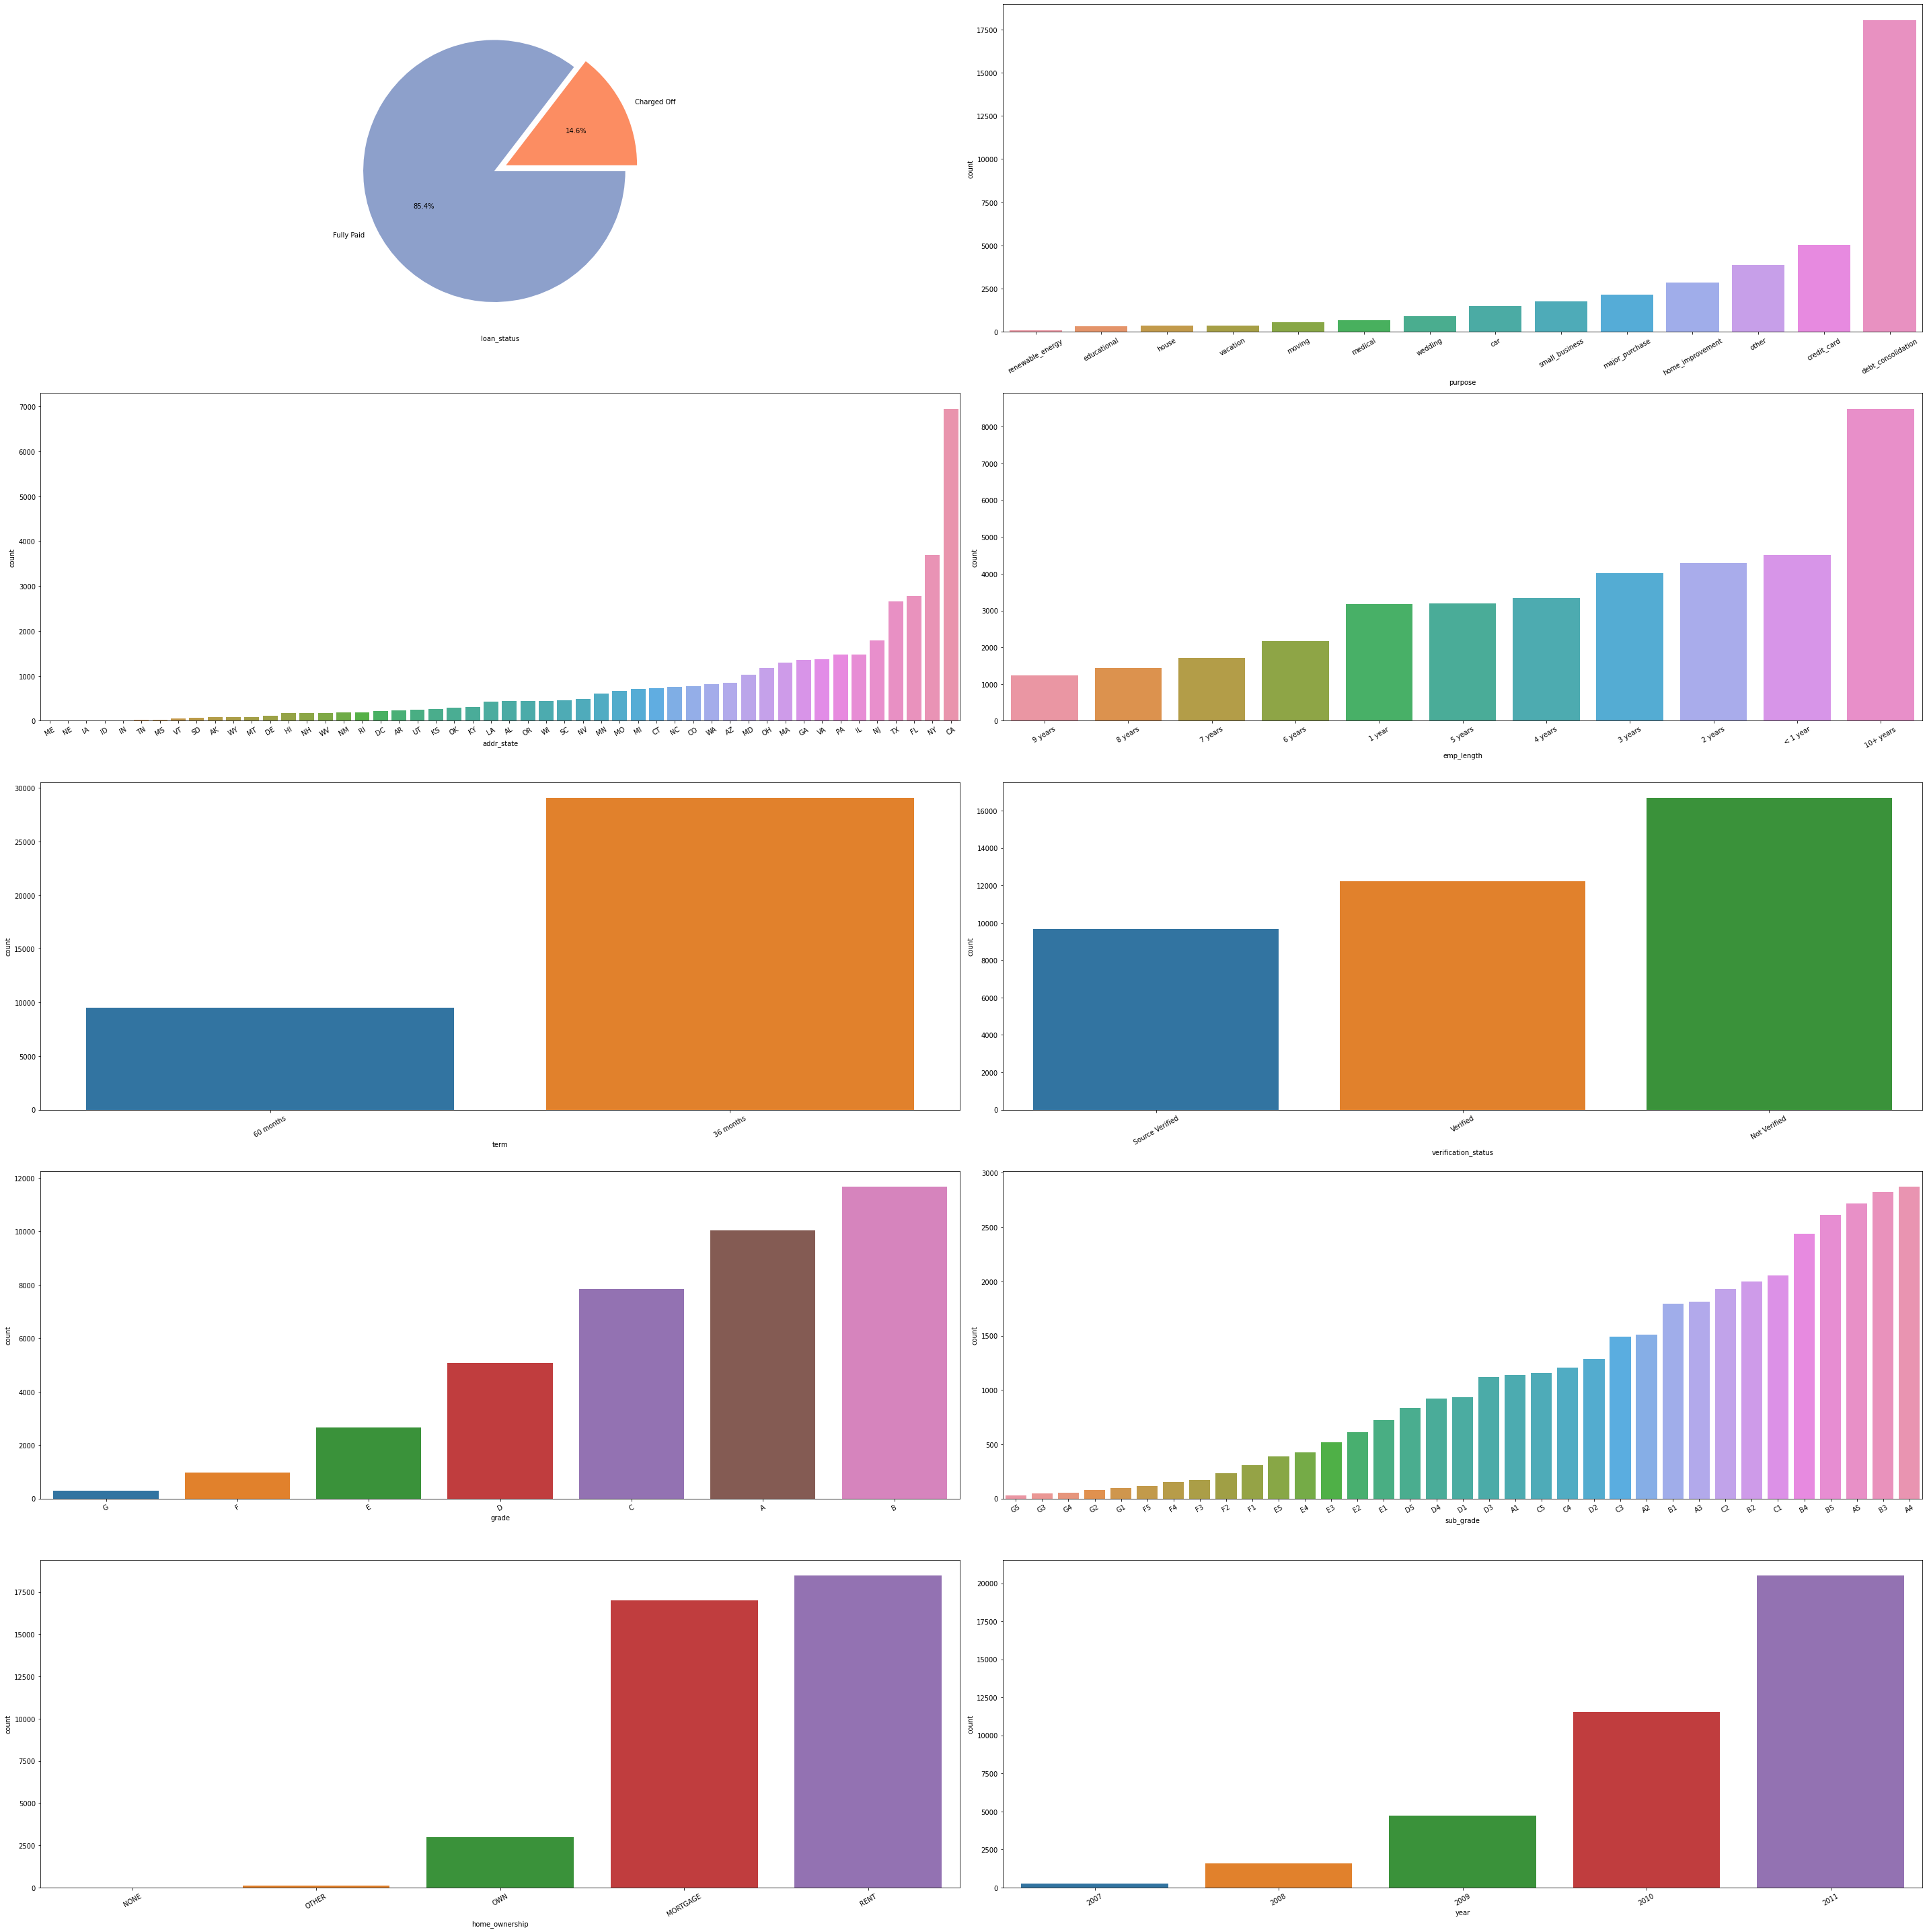

In [68]:
div, f_div = len(interested_uni_cat_variables)/2, len(interested_uni_cat_variables)//2
n_rows = f_div if div == f_div else f_div + 1

fig = plt.figure(figsize=(40, 40))
for ix, each_cat_var in enumerate(interested_uni_cat_variables):
    plt.subplot(n_rows, 2, ix+1)
    univ_cat_analysis(df, each_cat_var, each_cat_var!='loan_status')
plt.tight_layout()

,grade,total,total_default,rate
0,A,10045,602,0.059930
1,B,11675,1425,0.122056
2,C,7834,1347,0.171943
3,D,5085,1118,0.219862
4,E,2663,715,0.268494
5,F,976,319,0.326844
6,G,299,101,0.337793


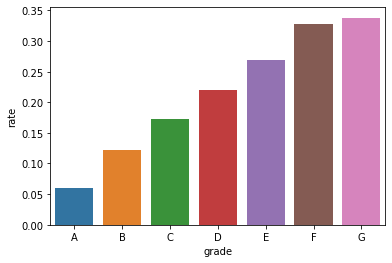

In [ ]:
agg_df = df.groupby('grade')[['defaulted']].agg(total=('defaulted', 'count'), total_default=('defaulted', 'sum')).reset_index()
agg_df['rate'] = agg_df.apply(lambda x: x['total_default']/x['total'], axis=1)
display(agg_df)
_ = sns.barplot(data=agg_df, x='grade', y='rate')

As above graph needs to be plotted for multiple variables, creating a common function

In [69]:
def bivar_plot(df, column):
    ax = sns.barplot(data=df, x=column, y='defaulted')

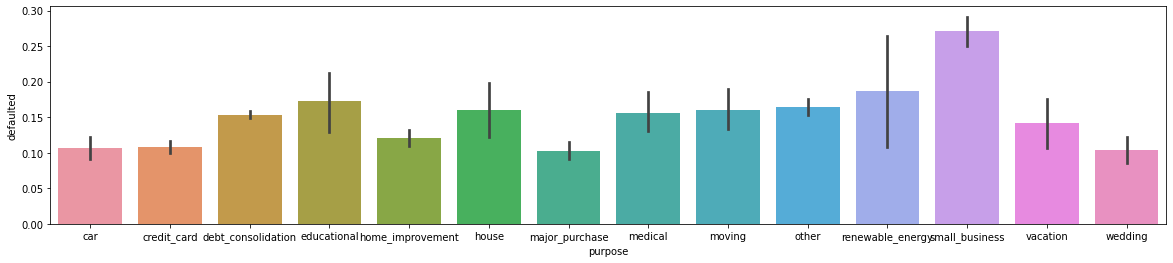

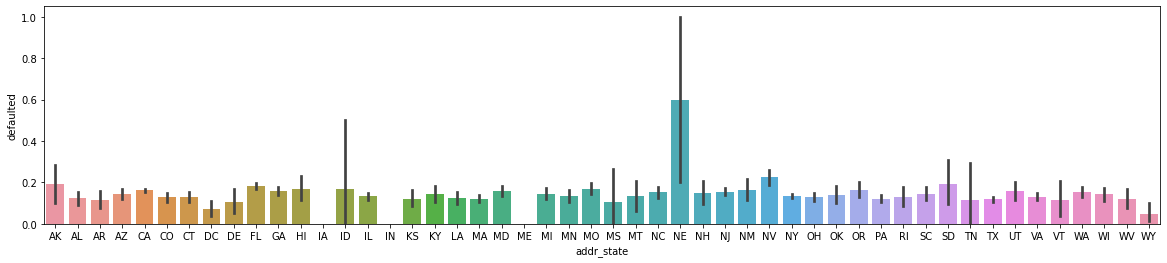

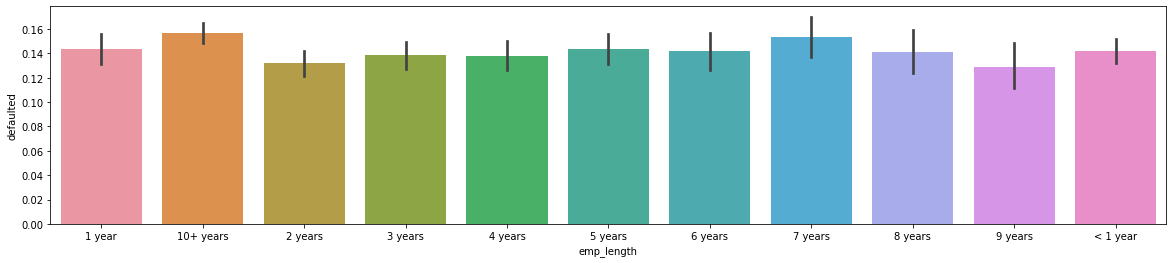

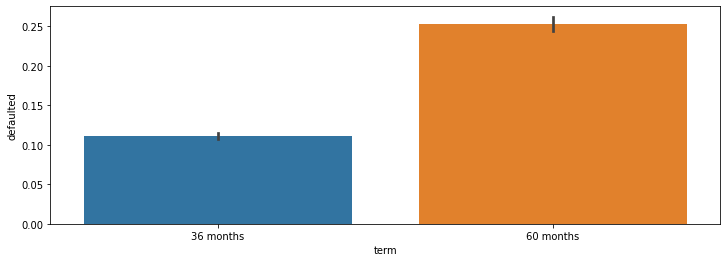

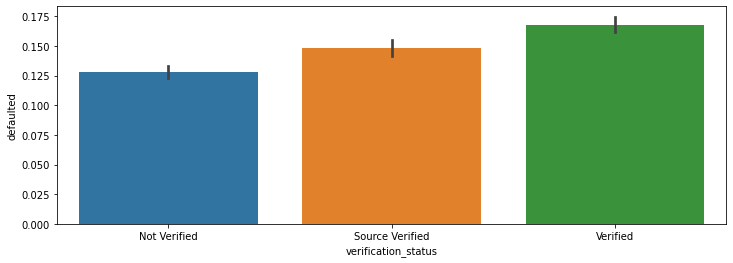

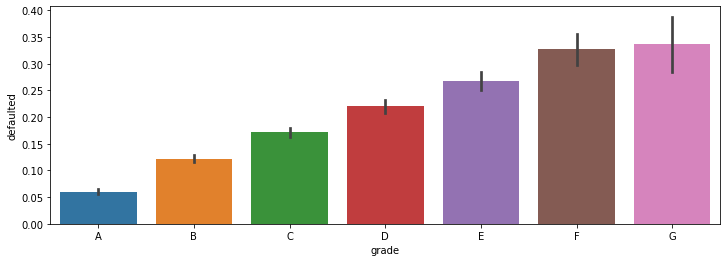

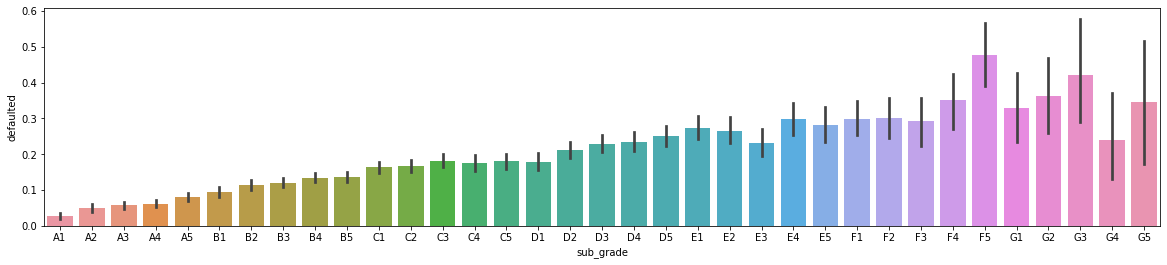

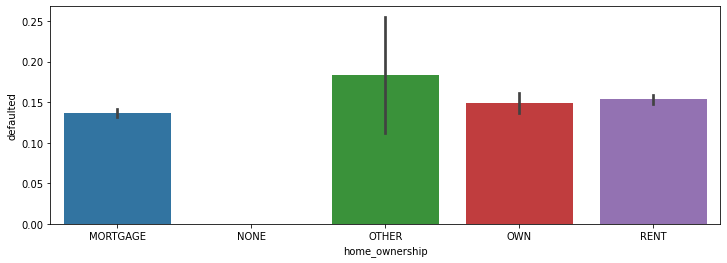

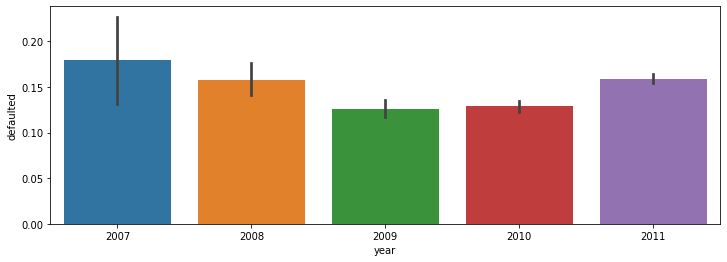

In [70]:
# for ix, each_cat_var in enumerate(interested_uni_cat_variables):
#     if each_cat_var!='loan_status':
#         n_uniq = len(df[each_cat_var].unique())
#         width = 12 if n_uniq < 10 else 20
#         plt.figure(figsize=(width, 4))
#         bivar_plot(df, each_cat_var)
#         plt.savefig("./outputs/bi_"+each_cat_var+".png", transparent=True)

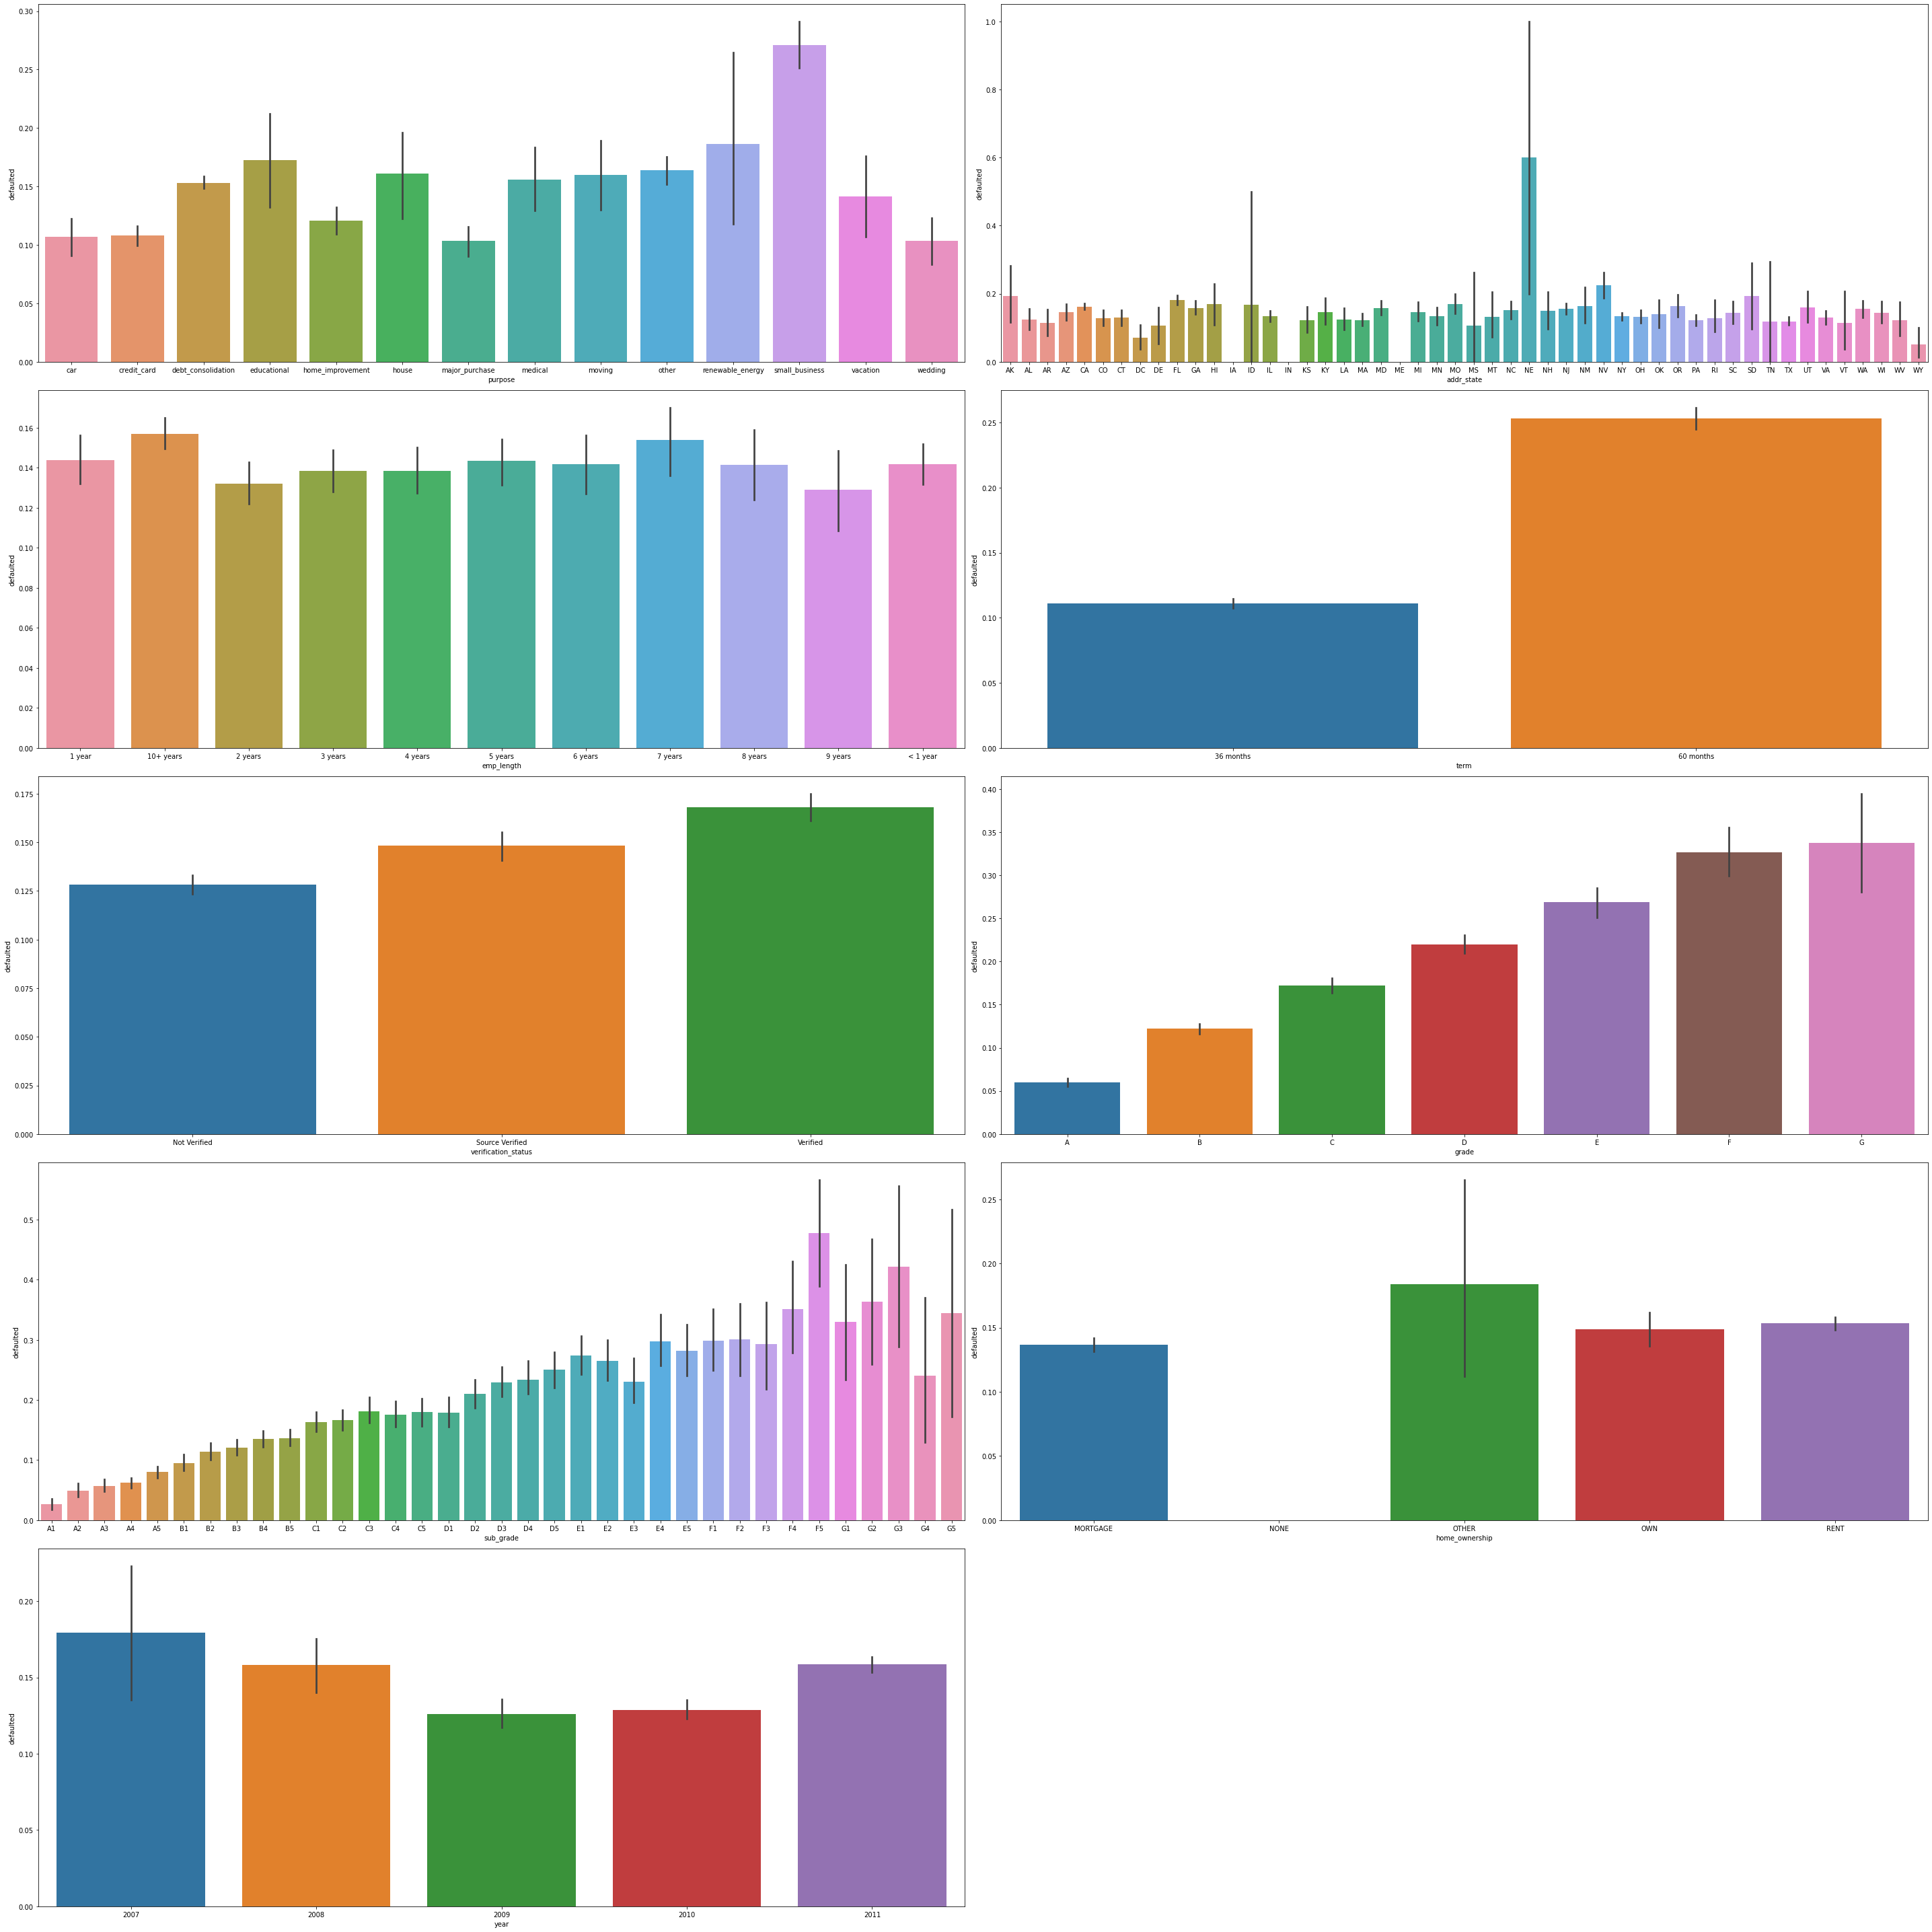

In [71]:
plt.figure(figsize=(40, 40))
c = 1
for ix, each_cat_var in enumerate(interested_uni_cat_variables):
    if each_cat_var!='loan_status':
        plt.subplot(n_rows, 2, c)
        bivar_plot(df, each_cat_var)
        c+=1
plt.tight_layout()

Correlation plots for loan_amnt, funded_amnt, funded_amount_inv

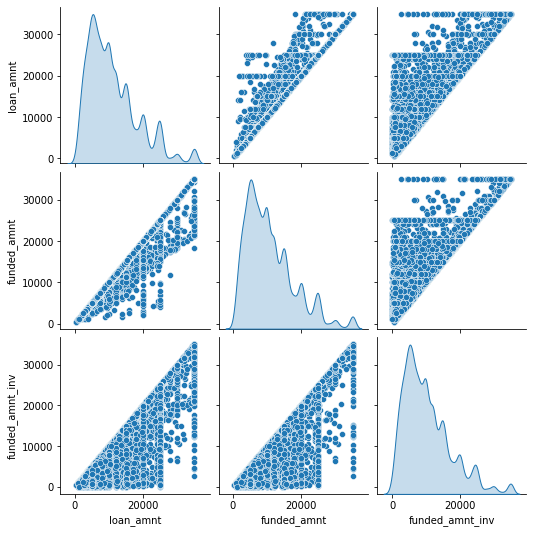

In [72]:
sns.pairplot(data=df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']], diag_kind = 'kde')

### Binning continuous variables



As distribution of following continuous variables didn't help much in deriving insights, hence created bins for them

In [74]:
df['loan_amnt_cat'] = pd.cut(df['loan_amnt'], bins=[df['loan_amnt'].min(), 5000, 15000, 25000, df['loan_amnt'].max()], labels=['low', 'medium', 'high', 'very high'])
df['int_rate_cat'] = pd.cut(df['int_rate'], 4, labels=['low', 'medium', 'high', 'very high'])
df['installment_cat'] = pd.cut(df['installment'],  bins=[df['installment'].min(), 200, 400, 600, df['installment'].max()], labels=['low', 'medium', 'high', 'very high'])


df['dti_cat'] = pd.cut(df['int_rate'], 3, labels=['low', 'medium', 'high'])
df['annual_inc_cat'] = pd.cut(df['annual_inc'], bins=[df['annual_inc'].min(), 50000, 100000, 150000, df['annual_inc'].max()], labels=['low', 'medium', 'high', 'very high'])

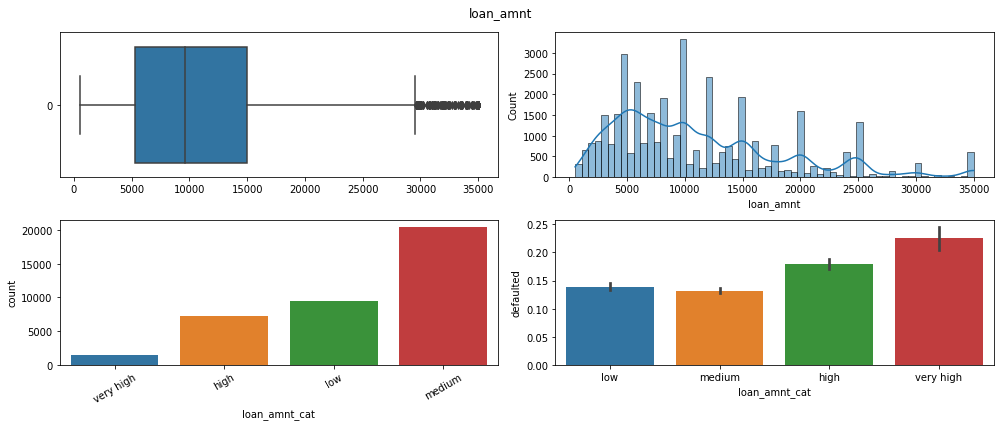

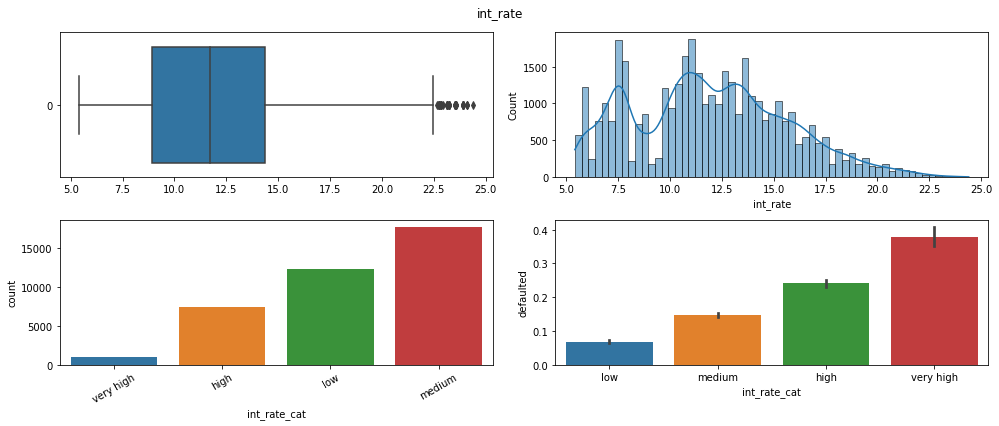

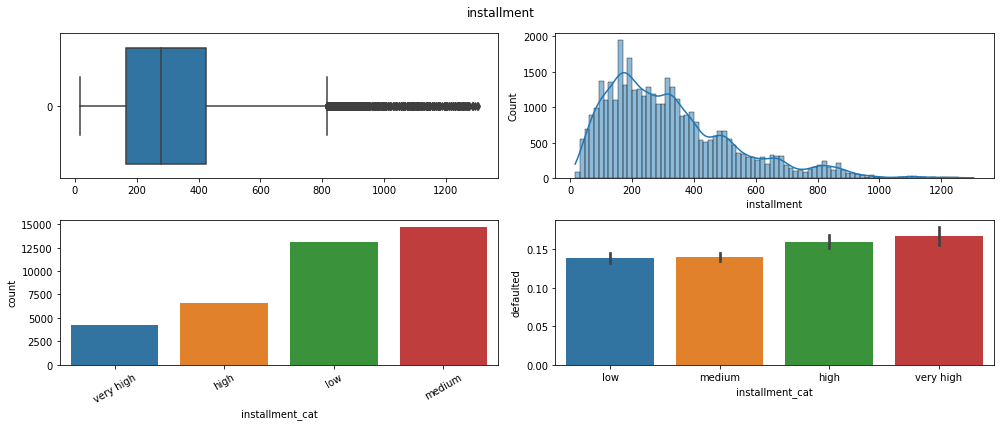

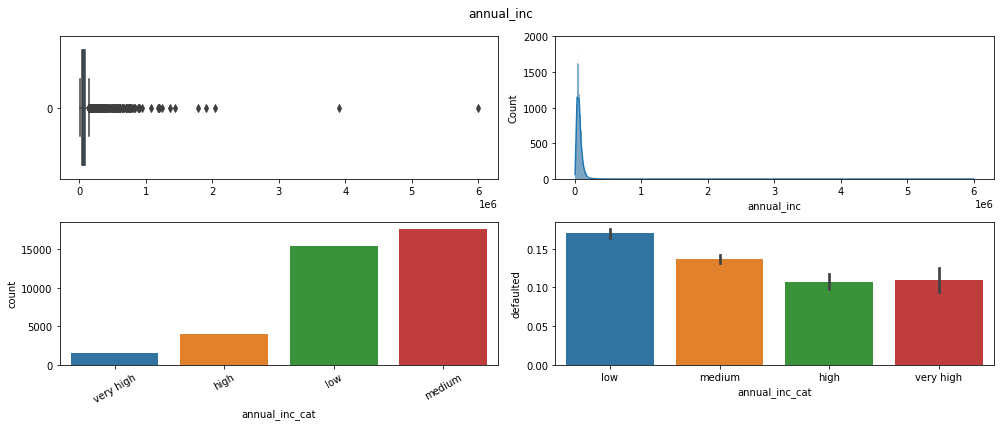

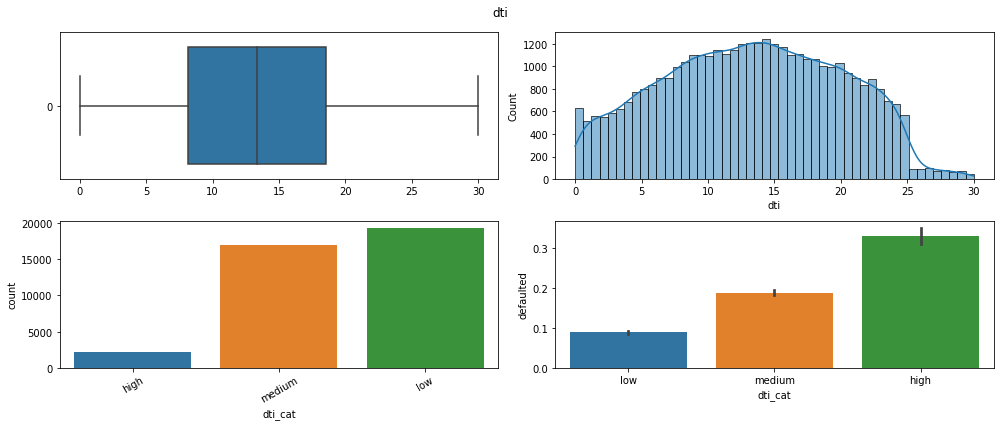

In [76]:
interested_num_variables = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']

for x in interested_num_variables:
    if x not in ('funded_amnt', 'funded_amnt_inv', 'defaulted'): #, 'installment', 'annual_inc'
        plt.figure(figsize=(14, 6))
        plt.subplot(2,2,1)
        plt.suptitle(x)
        sns.boxplot(data=df[x], orient='h')
        
        plt.subplot(2, 2, 2)
        sns.histplot(df, x=x, kde=True)

        plt.subplot(2, 2, 3)
        univ_cat_analysis(df, x+"_cat")

        plt.subplot(2, 2, 4)
        bivar_plot(df, x+"_cat")
        # plt.savefig("./outputs/num_"+x+".png", transparent=True)
    plt.tight_layout()

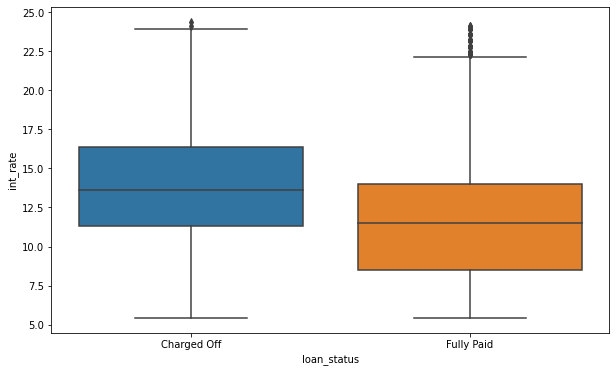

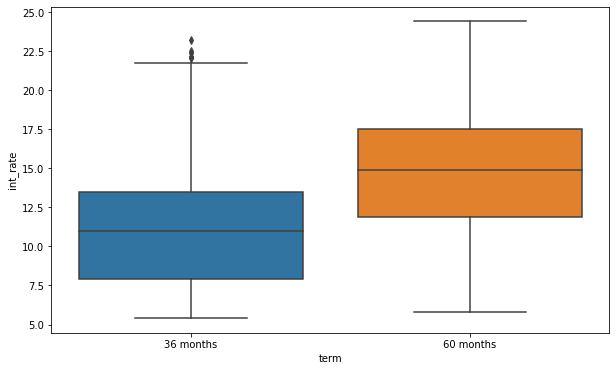

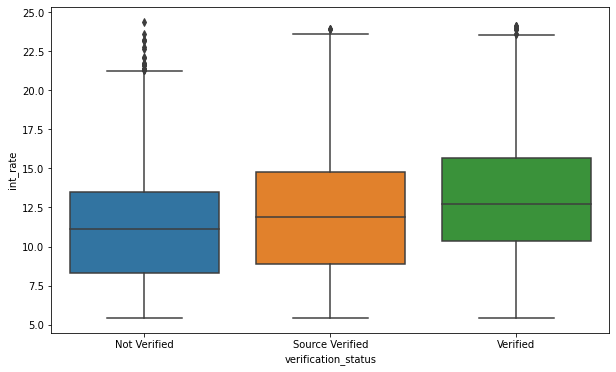

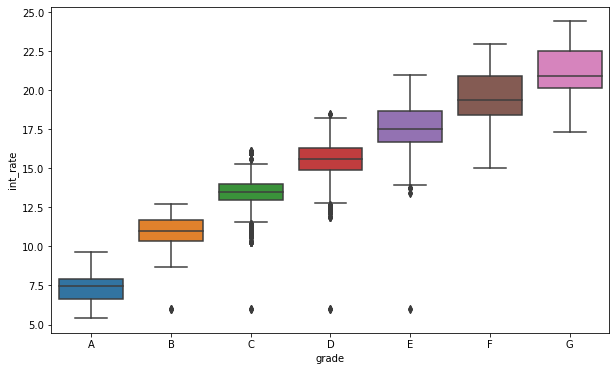

In [78]:
for x in ['loan_status', 'term', 'verification_status', 'grade']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=x, y='int_rate')
    # plt.savefig("./outputs/ir_"+x+".png", transparent=True)

### Segmented Univariate

We are considering following variable to prepare segments from above analysis:
1. verification_status
2. purpose (major 6)
3. int_rate
4. year-wise segments

In [79]:
purpose_top_6 = df.purpose.value_counts().reset_index()['index'].tolist()[:6]
purpose_top_6

['debt_consolidation',
 'credit_card',
 'other',
 'home_improvement',
 'major_purchase',
 'small_business']

<AxesSubplot:xlabel='verification_status', ylabel='defaulted'>

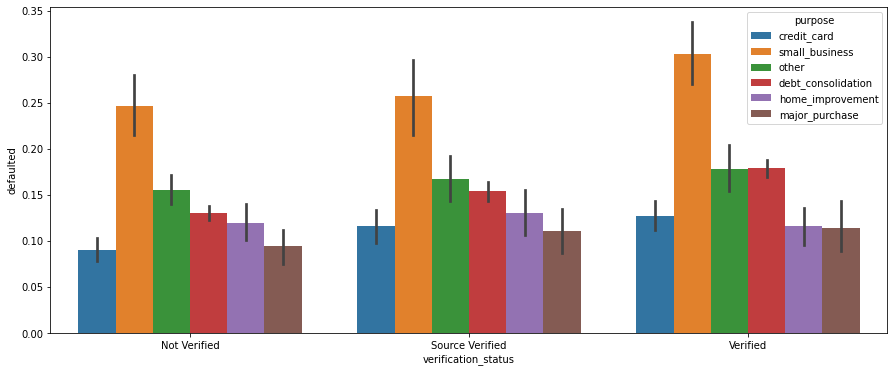

In [80]:
plt.figure(figsize=(15,6))
sns.barplot(data=df[df.purpose.isin(purpose_top_6)].astype({'purpose':'object'}), x='verification_status', y='defaulted', hue='purpose')

In [81]:
def segmented_plot(df, column, segment_col, filter=None):
    if filter:
        df = df[df[segment_col].isin(filter)].astype({segment_col:'object'})
    sns.barplot(data=df, x=column, y='defaulted', hue=segment_col)
    # plt.savefig("./outputs/segmented_"+column+"_"+segment_col+".png", transparent=True)

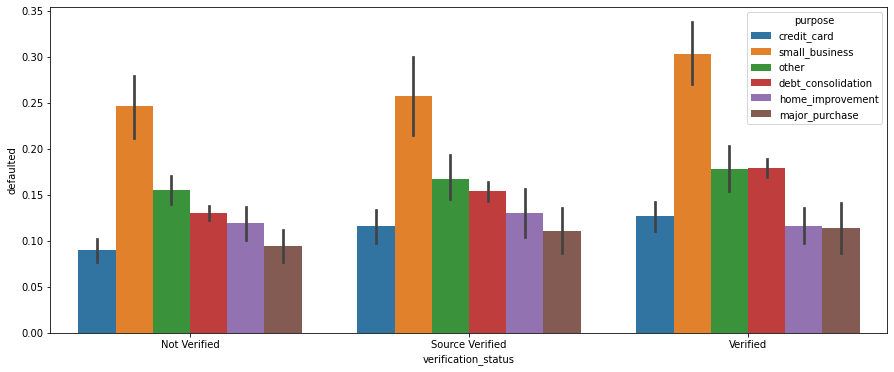

In [82]:
plt.figure(figsize=(15, 6))
segmented_plot(df, column='verification_status', segment_col='purpose', filter=purpose_top_6)

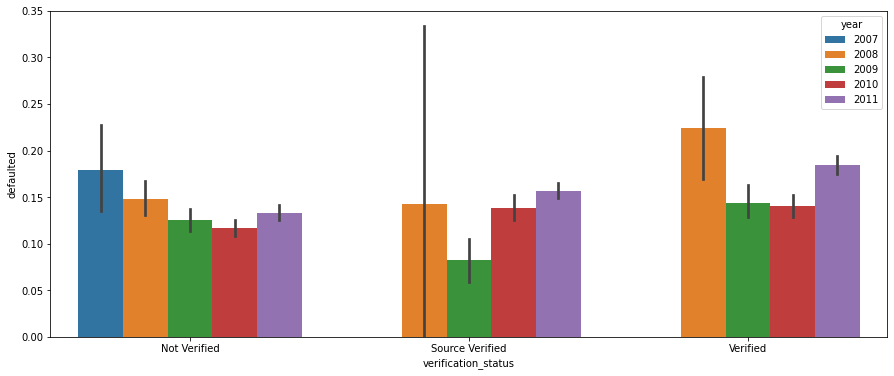

In [83]:
plt.figure(figsize=(15, 6))
segmented_plot(df, column='verification_status', segment_col='year')

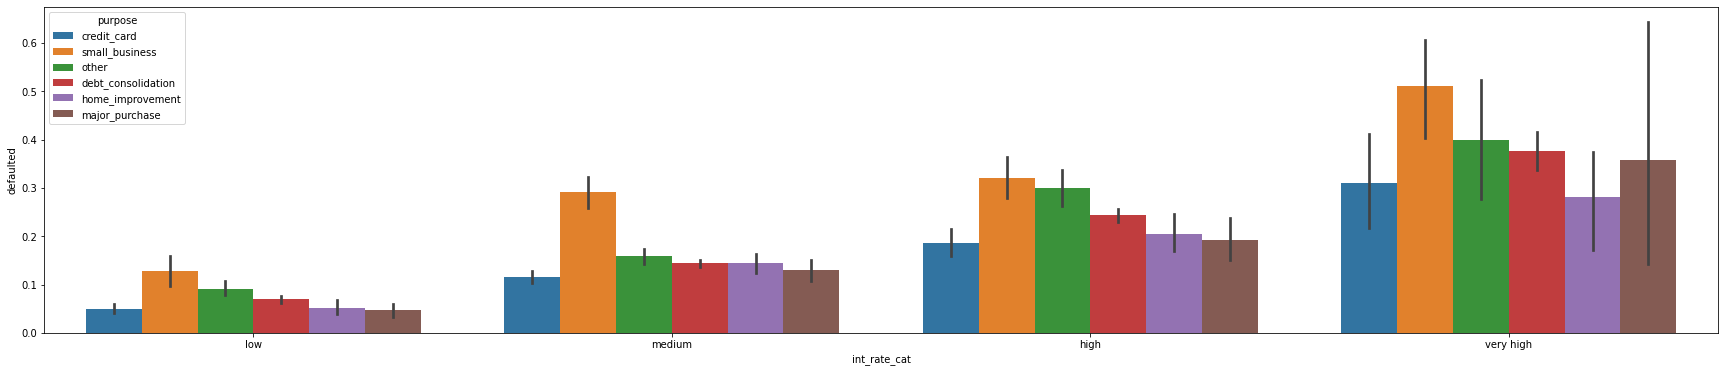

In [84]:
plt.figure(figsize=(30, 6))
segmented_plot(df, column='int_rate_cat', segment_col='purpose', filter=purpose_top_6)

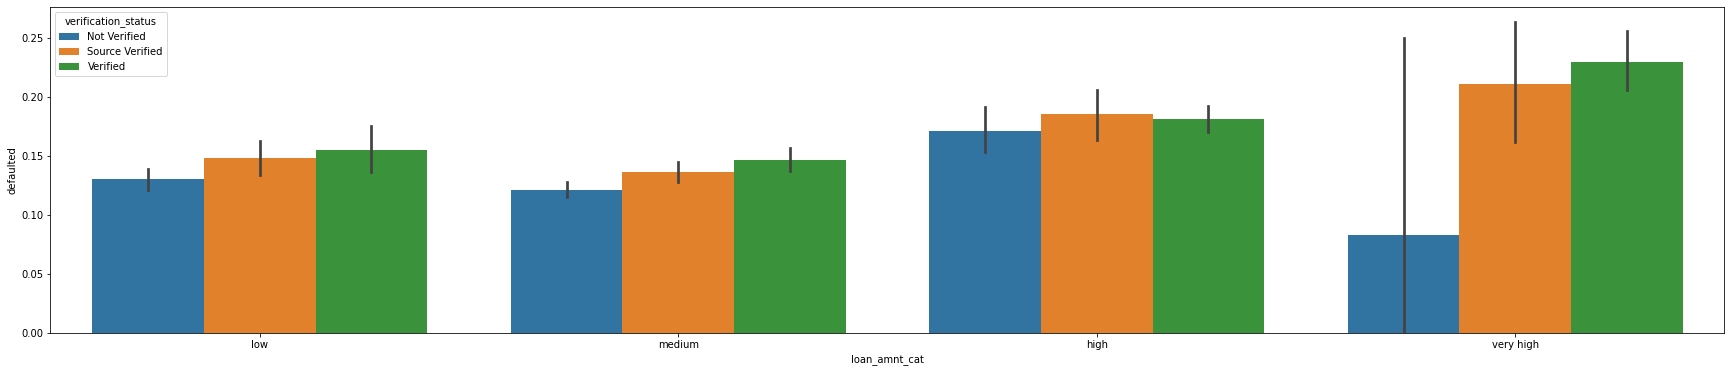

In [85]:
plt.figure(figsize=(30, 6))
segmented_plot(df, column='loan_amnt_cat', segment_col='verification_status')

#### Completed !